In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm # Used for SARIMAX (ARIMAX)

# --- 1. Create Hypothetical Data ---
np.random.seed(42)
index = pd.date_range(start='2000-01-01', periods=100, freq='M')
# Y: Retail Sales (with upward trend)
sales_Y = np.cumsum(np.random.randn(100) * 5 + 10) + np.linspace(0, 100, 100)
# X: Consumer Confidence (Exogenous Variable)
confidence_X = np.random.randn(100) * 3 + 100 + np.sin(np.linspace(0, 10, 100))

# Convert to Pandas Series
Y = pd.Series(sales_Y, index=index, name='Retail_Sales')
X = pd.Series(confidence_X, index=index, name='Consumer_Confidence')

# --- 2. Check and Difference Predictor X ---
# We assume Y needs d=1, so X must also be made stationary by differencing.
X_diff = X.diff().dropna()
# Ensure X is aligned with Y's differenced index (dropping the first NaN)
Y_diff = Y.diff().dropna()
X_diff = X_diff.loc[Y_diff.index] # Align X_diff to Y_diff
print("Data prepared and aligned for ARIMAX.")

Data prepared and aligned for ARIMAX.


C:\Users\andys\AppData\Local\Temp\ipykernel_61100\2352958243.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2000-01-01', periods=100, freq='M')


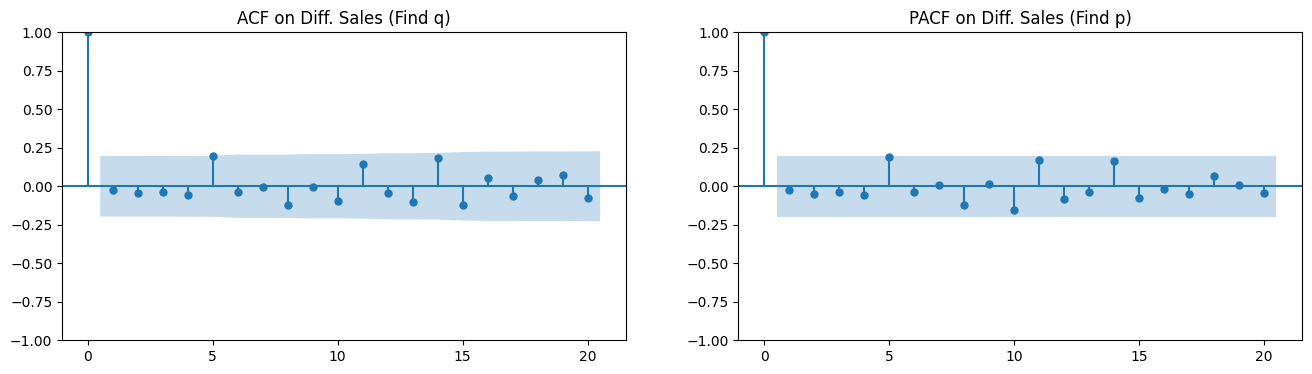

Non-seasonal orders chosen: p=1, d=1, q=1


In [2]:
# --- A. ADF Test (Simulated Result) ---
# We assume d=1 was chosen, meaning Y_diff is stationary.

# --- B. ACF/PACF Plotting for p and q ---
# Plotting the ACF and PACF on the stationary Y_diff series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(Y_diff, lags=20, ax=axes[0], title='ACF on Diff. Sales (Find q)')
plot_pacf(Y_diff, lags=20, ax=axes[1], title='PACF on Diff. Sales (Find p)')
plt.show()

# --- C. Order Selection ---
# Based on the visual analysis of ACF/PACF:
p_order = 1
d_order = 1
q_order = 1

print(f"Non-seasonal orders chosen: p={p_order}, d={d_order}, q={q_order}")


--- Final Model Summary (Including T-Tests and R-squared) ---
                               SARIMAX Results                                
Dep. Variable:           Retail_Sales   No. Observations:                   99
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -284.197
Date:                Sat, 08 Nov 2025   AIC                            576.393
Time:                        16:42:05   BIC                            586.650
Sample:                    02-29-2000   HQIC                           580.539
                         - 04-30-2008                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Consumer_Confidence     0.0336      0.063      0.538      0.591      -0.089       0.156
ar.L1                   1.0008      0.002

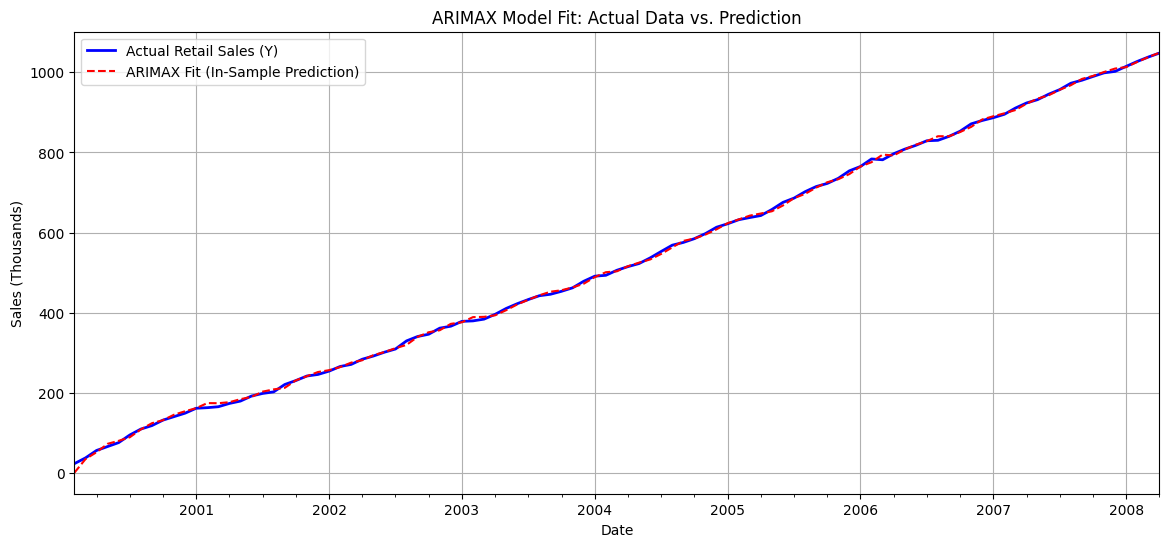

In [4]:
# --- A. Model Fitting (SARIMAX implementation of ARIMAX) ---
# First, align the data properly
Y_model = Y[1:]  # Remove the first observation to match X_diff's length
X_model = X_diff  # X_diff is already aligned with Y_model

# Fit the ARIMAX model with aligned data
arimax_model = sm.tsa.SARIMAX(
    Y_model,
    order=(p_order, d_order, q_order),
    exog=X_model,
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_results = arimax_model.fit(disp=False)

print("\n--- Final Model Summary (Including T-Tests and R-squared) ---")
print(arimax_results.summary())

# Generate predictions with aligned data
predictions = arimax_results.predict(start=0, end=len(Y_model)-1, exog=X_model)
predictions.name = 'ARIMAX Predictions'

# Plotting
plt.figure(figsize=(14, 6))
Y_model.plot(label='Actual Retail Sales (Y)', color='blue', linewidth=2)
predictions.plot(label='ARIMAX Fit (In-Sample Prediction)', color='red', linestyle='--')
plt.title('ARIMAX Model Fit: Actual Data vs. Prediction')
plt.xlabel('Date')
plt.ylabel('Sales (Thousands)')
plt.legend()
plt.grid(True)
plt.show()